In [ ]:
import numpy as np
import pandas as pd
import os
import imageio
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.ndimage as ndi

In [ ]:
from PIL import ImageFilter, Image, ImageOps
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# train dataset

dirname_train = '/content/drive/MyDrive/Deep_Learning_CT2/Chess/Train'
dir_chess_folders = os.listdir(dirname_train)
dir_chess_paths_T = [os.path.join(dirname_train, path) for path in dir_chess_folders]

In [ ]:
dir_chess_paths_T

['/content/drive/MyDrive/Deep_Learning_CT2/Chess/Train/Rook',
 '/content/drive/MyDrive/Deep_Learning_CT2/Chess/Train/Queen',
 '/content/drive/MyDrive/Deep_Learning_CT2/Chess/Train/Bishop',
 '/content/drive/MyDrive/Deep_Learning_CT2/Chess/Train/Pawn',
 '/content/drive/MyDrive/Deep_Learning_CT2/Chess/Train/Knight',
 '/content/drive/MyDrive/Deep_Learning_CT2/Chess/Train/King']

In [ ]:
# test dataset

dirname_test = '/content/drive/MyDrive/Deep_Learning_CT2/Chess/Test'
dir_chess_folders = os.listdir(dirname_test)
dir_chess_paths = [os.path.join(dirname_test, path) for path in dir_chess_folders]

In [ ]:
dir_chess_paths

['/content/drive/MyDrive/Deep_Learning_CT2/Chess/Test/Queen',
 '/content/drive/MyDrive/Deep_Learning_CT2/Chess/Test/King',
 '/content/drive/MyDrive/Deep_Learning_CT2/Chess/Test/Bishop',
 '/content/drive/MyDrive/Deep_Learning_CT2/Chess/Test/Pawn',
 '/content/drive/MyDrive/Deep_Learning_CT2/Chess/Test/Rook',
 '/content/drive/MyDrive/Deep_Learning_CT2/Chess/Test/Knight']

In [ ]:
def plot_imgs(item_dir, title=" ", num_imgs=4, cmap='viridis'):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(15, 15))
    for idx, img_path in enumerate(item_files):
        plt.subplot(8, 8, idx+1)
        img = plt.imread(img_path, 0)
        plt.title(title)
        plt.imshow(img, cmap=cmap)

    plt.tight_layout()

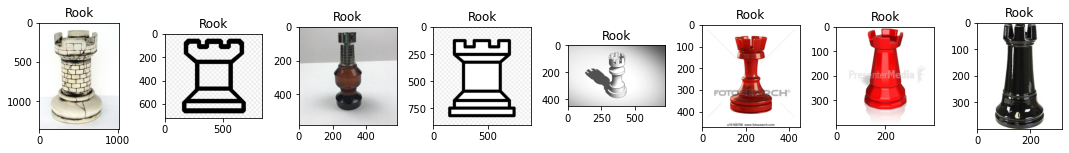

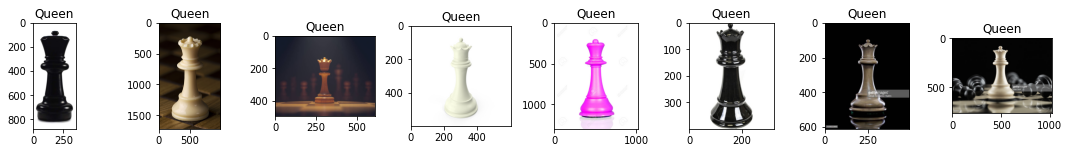

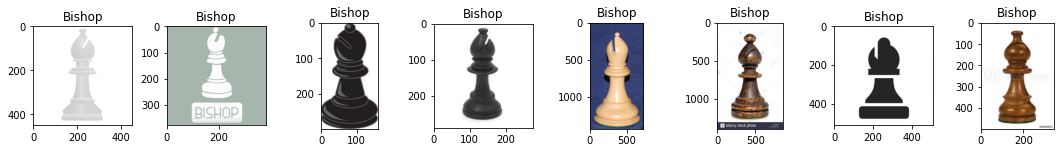

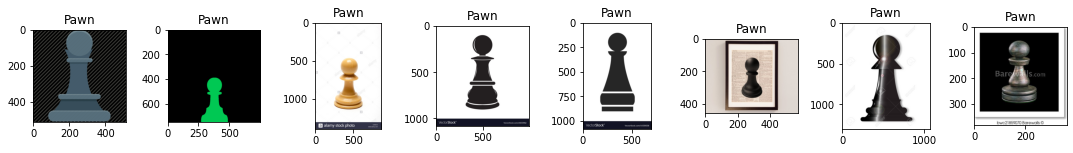

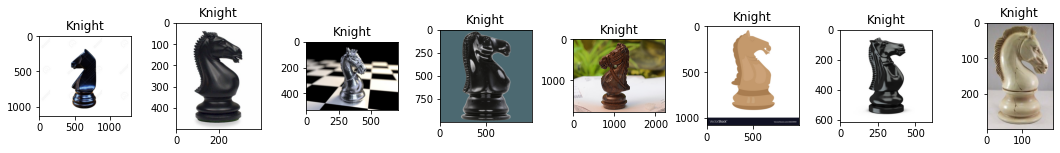

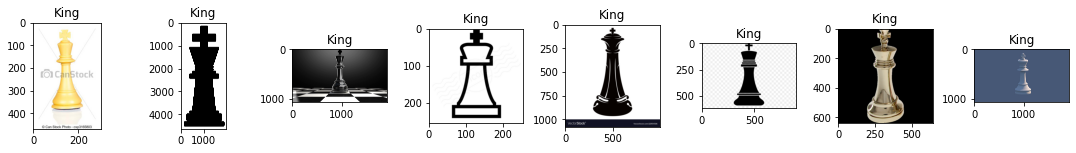

In [ ]:
for path in dir_chess_paths_T:
    head, tail = os.path.split(path)
    plot_imgs(path, tail, 8)

In [ ]:
chess_dic = {}
for path in dir_chess_paths:
    head, tail = os.path.split(path)
    chess_dic[tail] = len(os.listdir(path))

In [ ]:
label_list = ["{}: {}".format(key, chess_dic[key]) for key in chess_dic]

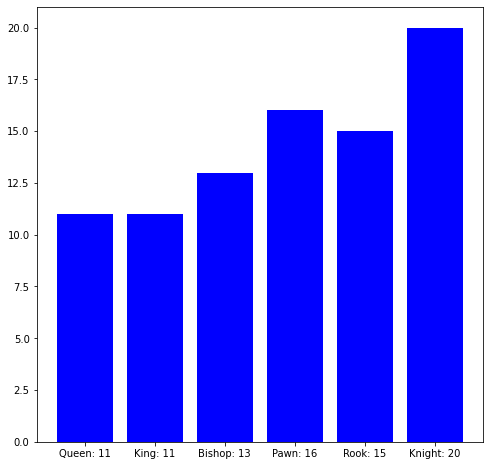

In [ ]:
plt.figure(figsize=(8, 8))
plt.bar(range(len(chess_dic)), list(chess_dic.values()), color="blue")
plt.xticks(range(len(chess_dic)), list(label_list))
plt.show();

In [ ]:
def plot_img_hist(item_dir, num_img=6):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_img]

    #plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(item_files):
        fig1 = plt.figure(idx,figsize=(10, 10))
        fig1.add_subplot(2, 2, 1)
        img = mpimg.imread(img_path, 0)
        plt.imshow(img)
        fig1.add_subplot(2, 2, 2)
        plt.hist(img.ravel(),bins=256, fc='k', ec='k')

    plt.tight_layout()

In [ ]:
img_size_h = 300
img_size_w = 300
batch_size = 16

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    rotation_range=90,
    width_shift_range=0.6,
    height_shift_range=0.6,
    shear_range=3, 
    zoom_range=50,
    horizontal_flip=True,
    vertical_flip=True)

In [ ]:

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Deep_Learning_CT2/Chess/Train',
    target_size=(img_size_h, img_size_w),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True, 
    seed=8)

validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Deep_Learning_CT2/Chess/Test',
    target_size=(img_size_h, img_size_w),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=7)

Found 336 images belonging to 6 classes.
Found 23 images belonging to 6 classes.


Conditions to consider:

*   Parameters should not cross 300000
*   Should not use more than 4 layers (except input and output, including convolution and dense layers)
*   Use Adam Optimizer

In [ ]:
input_shape = (img_size_h, img_size_w, 1)

In [ ]:
model = Sequential([

    Conv2D(16, (5,5), input_shape=input_shape, padding='same', activation='relu')

    Conv2D(16, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    BatchNormalization(momentum=0.3),
    Dropout(0.2),
    
    Conv2D(16, (5,5), padding='same', activation='relu'),    
    Conv2D(16, (3,3), padding='same', activation='relu'),
    Conv2D(32, (3,3), padding='same', activation='relu'),

    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    BatchNormalization(momentum=0.3),
    Dropout(0.2),
    
    Flatten(),
    
    # Dense(4, activation='relu'),
    Dropout(0.4),
    # Dense(6, activation='softmax')
    
])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 300, 300, 16)      416       
                                                                 
 conv2d_13 (Conv2D)          (None, 300, 300, 16)      2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 150, 150, 16)     0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 150, 150, 16)     64        
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 150, 150, 16)      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 150, 150, 16)     

Improve the baseline model (model build in question2) performance and
save the weights of improved model.
Conditions to consider:

*   Apply Data Augmentation if required
*   No parameter limits
*   Can use any number of layers
*   Use any optimizers of your choice
*   Use early stopping and save best model callbacks


In [ ]:
model = Sequential([

    Conv2D(16, (5,5), input_shape=input_shape, padding='same', activation='relu'),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    Conv2D(32, (3,3), padding='same', activation='relu'),

    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    BatchNormalization(momentum=0.3),
    Dropout(0.2),
    
    Conv2D(32, (5,5), padding='same', activation='relu'),    
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), padding='same', activation='relu'),

    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    BatchNormalization(momentum=0.3),
    Dropout(0.2),

    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(6, activation='softmax')
    
    
])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 300, 300, 16)      416       
                                                                 
 conv2d_19 (Conv2D)          (None, 300, 300, 32)      4640      
                                                                 
 conv2d_20 (Conv2D)          (None, 300, 300, 32)      9248      
                                                                 
 conv2d_21 (Conv2D)          (None, 300, 300, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 150, 150, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                      

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0005) 
callback = [learning_rate_reduction]

In [ ]:
history = model.fit_generator(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks = callback
    )

<ipython-input-34-c5bfae38a568>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
21/21 [==============================] - 188s 9s/step - loss: 60.6123 - accuracy: 0.1548 - val_loss: 7.8561 - val_accuracy: 0.1739 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 9s 404ms/step - loss: 3.0499 - accuracy: 0.2083 - val_loss: 1.7802 - val_accuracy: 0.2174 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - 9s 398ms/step - loss: 1.7923 - accuracy: 0.1964 - val_loss: 1.7898 - val_accuracy: 0.1739 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - ETA: 0s - loss: 1.8017 - accuracy: 0.1994
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
21/21 [==============================] - 10s 458ms/step - loss: 1.8017 - accuracy: 0.1994 - val_loss: 1.7892 - val_accuracy: 0.1739 - lr: 0.0010
Epoch 5/50
21/21 [==============================] - 8s 394ms/step - loss: 1.8685 - accuracy: 0.2024 - val_loss: 1.7887 - val_accuracy: 0.1739 - lr: 5.0000e-04
Epoch 6/50
21/21 [==============================] - 10s 496ms

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.python.client import device_lib
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.preprocessing import image

In [ ]:
def checkpoint_dir():
    checkpoint_dir = 'checkpoints/'
    
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
        
    return checkpoint_dir

def checkpoint_path():
    
    return os.path.join(checkpoint_dir(), 'model_checkpoint')

def checkpoint_saver():
    checkpoint = tf.compat.v1.train.Saver()
    checkpoint_dir_ = checkpoint_dir()
    checkpoint_path_ = checkpoint_path()
    
    return checkpoint

In [ ]:
def chess_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(1024, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(2048, kernel_size=(3, 5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=2048, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=5, activation='softmax')
    ])
    
    checkpoint_path_ = checkpoint_path()
    
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path_,
        save_weights_only=False,
        monitor='loss',
        mode='min',
        save_best_only=True
    )
    
    callbacks = [
        EarlyStopping(patience=10),
        model_checkpoint_callback
    ]
    
    return model, callbacks

model, callbacks = chess_model()

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_22 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_41 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_23 (Bat  (None, 64, 64, 64)      

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

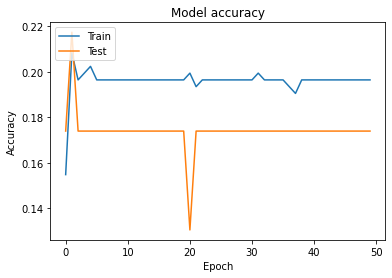

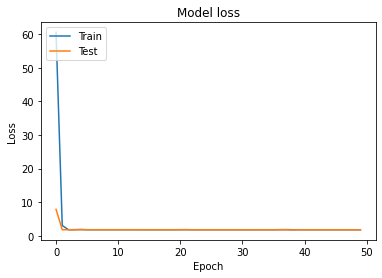

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
num_of_test_samples = 162 

In [ ]:
# Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

matrix1 = confusion_matrix(validation_generator.classes, y_pred)

<ipython-input-38-b64aa2cf1ded>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
